## Create Bilayer Topology with Stitch

OpenPNM includes numerous tools for manipulating and altering the topology.  Most of these are found in the **topotools** submodule. This example will illustrate how to join or 'stitch' two distinct networks, even if they have different lattice spacing. In this example we'll create a coarse and a fine network then stitch them together to make a network with two distinct layers.  

Start by creating a network with a large lattice spacing:

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import openpnm as op
%matplotlib inline
np.random.seed(10)
ws = op.Workspace()
ws.settings["loglevel"] = 40

In [2]:
coarse_net = op.network.Cubic(shape=[10, 10, 10], spacing=50e-6, name='coarse_net')
print(coarse_net)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.Cubic : coarse_net
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                    1000 / 1000 
2     throat.conns                                   2700 / 2700 
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      1000      
2     pore.back                                     100       
3     pore.bottom                                   100       
4     pore.front                                    100       
5     pore.internal                               

The ```coarse_net``` network has 1000 pores in a cubic lattice with a spacing of 50 um for a total size of 500 um per size.  Next, we'll make another network with smaller spacing between pores, but with the same total size.

In [3]:
fine_net = op.network.Cubic(shape=[25, 25, 5], spacing=20e-6, name='fine_net')
print(fine_net)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.Cubic : fine_net
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                    3125 / 3125 
2     throat.conns                                   8500 / 8500 
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      3125      
2     pore.back                                     125       
3     pore.bottom                                   625       
4     pore.front                                    125       
5     pore.internal                                 

These two networks are totally independent of each other, and actually both spatially overlap each other since the network generator places the pores at the [0, 0, 0] origin.  Combining these networks into a single network is possible using the ```stitch``` function, but first we must make some adjustments.  For starters, let's shift the ```fine_net``` along the z-axis so it is beside the ```coarse_net``` to give the layered effect:

In [4]:
fine_net['pore.coords'] += sp.array([0, 0, 10 * 50e-6])

<ipython-input-4-1898b4b525ae>:1: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  fine_net['pore.coords'] += sp.array([0, 0, 10 * 50e-6])


Before proceeding, let's quickly check that the two networks are indeed spatially separated now.  OpenPNM as a rule does *not* provide extensively visualization capabilities since there are so many other packages that do it very well.  However, we've found it useful to have a quick way of checking the network, so provide two tools in the ``topotools`` module: ``plot_connections`` and ``plot_coordinates``.  Below we'll use ``plot_connections``:

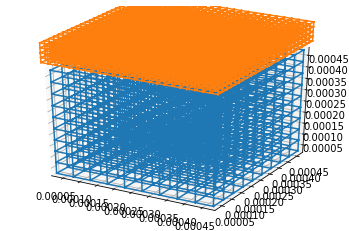

In [5]:
#NBVAL_IGNORE_OUTPUT
fig = op.topotools.plot_connections(coarse_net)
fig = op.topotools.plot_connections(fine_net, fig=fig)

As can be seen below, ```fine_net``` (orange) has been repositioned above the ```coarse_net``` (blue) because we shifted the z-coordinate by 500 um. (10 pores as 50 um per pore).

Now it's time stitch the networks together by adding throats between the pores on the top of the coarse network and those on the bottom of the fine network. The ```stitch``` function uses Euclidean distance to determine which pore is each face is nearest each other, and connects them. 

In [6]:
op.topotools.stitch(network=fine_net,
                    donor=coarse_net,
                    P_network=fine_net.pores('bottom'),
                    P_donor=coarse_net.pores('top'),
                    len_max=4e-5)

And we can quickly visualize the result using OpenPNM's plotting tools:

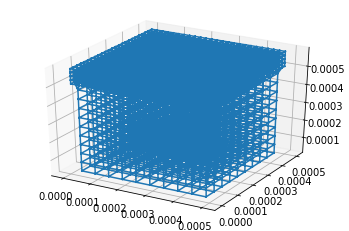

In [7]:
#NBVAL_IGNORE_OUTPUT
fig = op.topotools.plot_connections(fine_net)

The diagonal throats between the two networks have been added by the stitch process. The next step would be to assign different geometry objects to each network, with different pore sizes and such.